# Ensembles warm up: Random Forest
Random forest fits multiple trees on random subsets of examples and features. They are better than raw decision trees almost in every respect - with the exceptions of interpretability and computational cost.

Compared to boosting, the advantages are:
* Harder to overfit. Overfitting will not be made worse by adding more trees.
* Very easy to implement parallel training. If you ever have to do it by yourself for whatever reason...

Compared to boosting, the disadvantage is worse quality.

Please take your time to enjoy the beatiful smooth decision surface:


In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.metrics import accuracy_score
import matplotlib
def plot_decision_surface(clf,
                          X: np.ndarray,
                          y: np.ndarray,
                          grid_step: float=0.02,
                          cmap='bwr',
                          alpha:float=0.6,
                          axes=None
        ):
    """
    Plot the decision surface of a classifier, visualize selected points
    Args:
      clf: a fitted model, must support predict method
      X[n_examples, n_features]: points where to evaluate the classifier
      y[n_examples]: true labels
      grid_step: decision surface plottting grid
      alpha: opacity of the decision surface
      axes(matplotlib.axes._subplots.AxesSubplot): axes where plot, if None, a new figure is created
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    if axes is None:
      _, axes = plt.subplots()
    axes.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    axes.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    axes.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    axes.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    axes.legend(loc='best')

In [4]:
# The data should be in CoCalc. If it isn't, we are soory for that, it can be downloaded here:
# https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz
#! wget https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz

In [5]:
# If you usder wget
# DATA_FOLDER = "."
DATA_FOLDER = "../../data/1.6.1-ensembles"
muticlass_toy_data = np.load(os.path.join(DATA_FOLDER, "data.npz"))
X_toy_multiclass_train, X_toy_multiclass_test, \
  y_toy_multiclass_train, y_toy_multiclass_test = \
    train_test_split(muticlass_toy_data["X"], muticlass_toy_data["y"],
                     test_size=0.5, random_state=421)

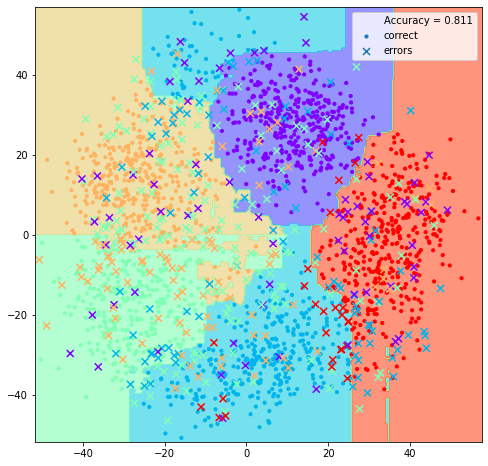

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Note the n_jobs parameter: it defines the number of parallel training processes
# -1 means to use all available
random_forest = RandomForestClassifier(n_estimators=100,
                                       min_samples_leaf=5,
                                       n_jobs=-1, random_state=3421)

random_forest.fit(X_toy_multiclass_train, y_toy_multiclass_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(random_forest,
                      X_toy_multiclass_test,
                      y_toy_multiclass_test,
                      cmap='rainbow', grid_step=0.4, axes=ax)

# An interlude on uncertainty
*  Quality of an ML algorithm "in general" is hard to define and, in complete absense of assumptions on the data, all algorithms have the same performance - [no free lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem)
*  Performance of a **particular** trained model on a **particular** test dataset is, however, a simple statistical problem you all are familiar with. Example loss is an i. i. d. random variable, algorithm performance is its expeted value, this is it.
* As AUC is not an expectation of some **per-example** loss, the statistics is a lot trickier. See the [paper](https://ieeexplore.ieee.org/document/6851192/) and a [python implementation](https://github.com/yandexdataschool/roc_comparison/)

## Task 3 (difficulty: statistics 101)
Compute the t-statistic and p-value and for hypothesis that random forest average accuracy is equal to decision tree accuracy on the `toy_multiclass_test` dataset
* for the whole test dataset
* for the subset consisting of the first 5 examples of the test dataset

In [7]:
from scipy import stats
### Write your code here ###
# For the benefit of the checker, please store the results in the following variables:
# full_test_p_value and test_5_p_value
# Your good friends here are
# - the definition of accuracy mean(predicted_label == real_label)
# - T-test and its Python implementation: scipy.stats.ttest_ind

In [8]:
predictions_forest = random_forest.predict(X_toy_multiclass_test)
predictions_tree = DecisionTreeClassifier(random_state=234).fit(
    X_toy_multiclass_train, y_toy_multiclass_train).predict(X_toy_multiclass_test)

In [9]:
forest = np.array((predictions_forest == y_toy_multiclass_test), dtype=np.float)
tree = np.array((predictions_tree == y_toy_multiclass_test), dtype=np.float)

full_test_p_value = stats.ttest_ind(forest, tree).pvalue
test_5_p_value = stats.ttest_ind(forest[:5], tree[:5]).pvalue

In [10]:
print(full_test_p_value, test_5_p_value)

5.327000582272535e-17 0.3465935070873342
